In [66]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import keplergl
from tqdm import tqdm
import matplotlib.pyplot as plt
import h3
import re
from geopy import Nominatim, location
from geopy.extra.rate_limiter import RateLimiter
import googlemaps
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from scipy.stats import shapiro, fligner

In [67]:
previous_data = 'datasets/houses_dataset_after_cleaning.csv'
prev_df = pd.read_csv(previous_data)
target = prev_df['buy_price'] # Repaso
prev_df.drop(
    ['Unnamed: 0', 'id', 'subtitle', 'full_title', 'operation', 'house_type_id', 'energy_certificate'],
    axis=1,
    inplace=True
)

Tras analizar y eliminar en una primera selección aquellas columnas con un porcentaje de valores nulos superior al 75%, se va a realizar un segundo análisis para entender los valores nulos y ver cómo abordar su consiguiente tratamiento. Tras finalizar con el análisis de valores nulos se realizará un análisis de outliers, con vistas a entender qué valores atípicos tenemos en el conjunto de datos y si alguno debe ser eliminado del conjunto de datos. En la memoria de la práctica se explicará el razonamiento seguido a lo largo del desarrollo del código.

In [68]:
# First nan analysis
columns = prev_df.columns.to_list()
for c in columns:
    if prev_df[c].isnull().sum() > 0:
        print(c)
        print(set(prev_df[c].unique()))


sq_mt_useful
{1.0, 2.0, 523.0, 12.0, 13.0, 19.0, 20.0, 21.0, 22.0, 23.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, nan, 161.0, 162.0, 164.0, 165.0, 166.0, 167.0, 168.0, 163

1. price_per_m2, sq_m_useful -> Se va a rellenar con el valor de su mediana al tratarse de valores continuos
2. has_terrace, has_storage_room, has_fitted_wardrobes, has_ac -> asumimos nan como false, y por tanto 0
3. En el caso de valores categóricos, vemos el porcentaje de valores que faltan

In [69]:
cont_cols = ['price_per_m2', 'sq_mt_useful']
for c in cont_cols:
    prev_df[c].fillna(prev_df[c].median(), inplace=True)

In [70]:
bin_cols = [
    'has_terrace', 'has_storage_room',
    'has_fitted_wardrobes', 'has_ac'
]
for c in bin_cols:
    prev_df[c] = prev_df[c].fillna(0.0)

In [71]:
# na_df = (df.isnull().sum() / len(df)) * 100
bin_with_nan_cols = [
    'n_bathrooms', 'floor', 'is_floor_under',
    'is_new_development', 'has_central_heating', 'has_individual_heating',
    'has_lift', 'is_exterior'
]
for c in bin_with_nan_cols:
    perc = prev_df[c].isnull().sum() / len(prev_df[c]) * 100
    print('{}  has {} missing values.'.format(c, perc))

n_bathrooms  has 0.10182147301730966 missing values.
floor  has 2.2061319153750425 missing values.
is_floor_under  has 2.2061319153750425 missing values.
is_new_development  has 4.97793868084625 missing values.
has_central_heating  has 33.499264622694874 missing values.
has_individual_heating  has 33.499264622694874 missing values.
has_lift  has 2.296639891390429 missing values.
is_exterior  has 5.498359542934721 missing values.


Podemos ver que salvo los valores de calefacción central/individual, el resto tienen unos porcentajes muy pequeños, por lo que vamos a quitar todas las filas que contengan valores nulos y vamos a quitar las columnas de calefacción, ya que en este caso no creemos que aporten demasiado a la hipótesis de la gentrificación.

In [72]:
prev_df.drop(['has_central_heating', 'has_individual_heating'], axis=1, inplace=True)

In [73]:
# na_df = (df.isnull().sum() / len(df)) * 100
bin_with_nan_cols = [
    'n_bathrooms', 'floor', 'is_floor_under',
    'is_new_development',
    'has_lift', 'is_exterior'
]
prev_df.dropna(subset=bin_with_nan_cols, inplace=True)

In [74]:
columns = prev_df.columns.to_list()
for c in columns:
    if prev_df[c].isnull().sum() > 0:
        print(c)
        print(set(prev_df[c].unique()))

In [75]:
# Convertimos valores de floor a numéricos
floor_replace_dict = {
    '0': [
        'Sótano',
        'Bajo',
        'Sótano exterior',
        'Sótano interior',
        'Semi-sótano interior',
        'Semi-sótano exterior'
    ],
    '1': [
        'Entreplanta',
        'Entreplanta interior', 
        'Entreplanta exterior'
    ]
}
prev_df['floor'].replace(floor_replace_dict['0'], '0', inplace=True) # For box-cox
prev_df['floor'].replace(floor_replace_dict['1'], '1', inplace=True)
prev_df['floor'] = pd.to_numeric(prev_df['floor'], errors='coerce')

In [76]:
prev_df.loc[prev_df['buy_for_rent_ratio'] < 0, 'buy_for_rent_ratio'] = 0
prev_df = prev_df.drop(prev_df.loc[prev_df['buy_for_rent_ratio'] == 0].index)

<Axes: >

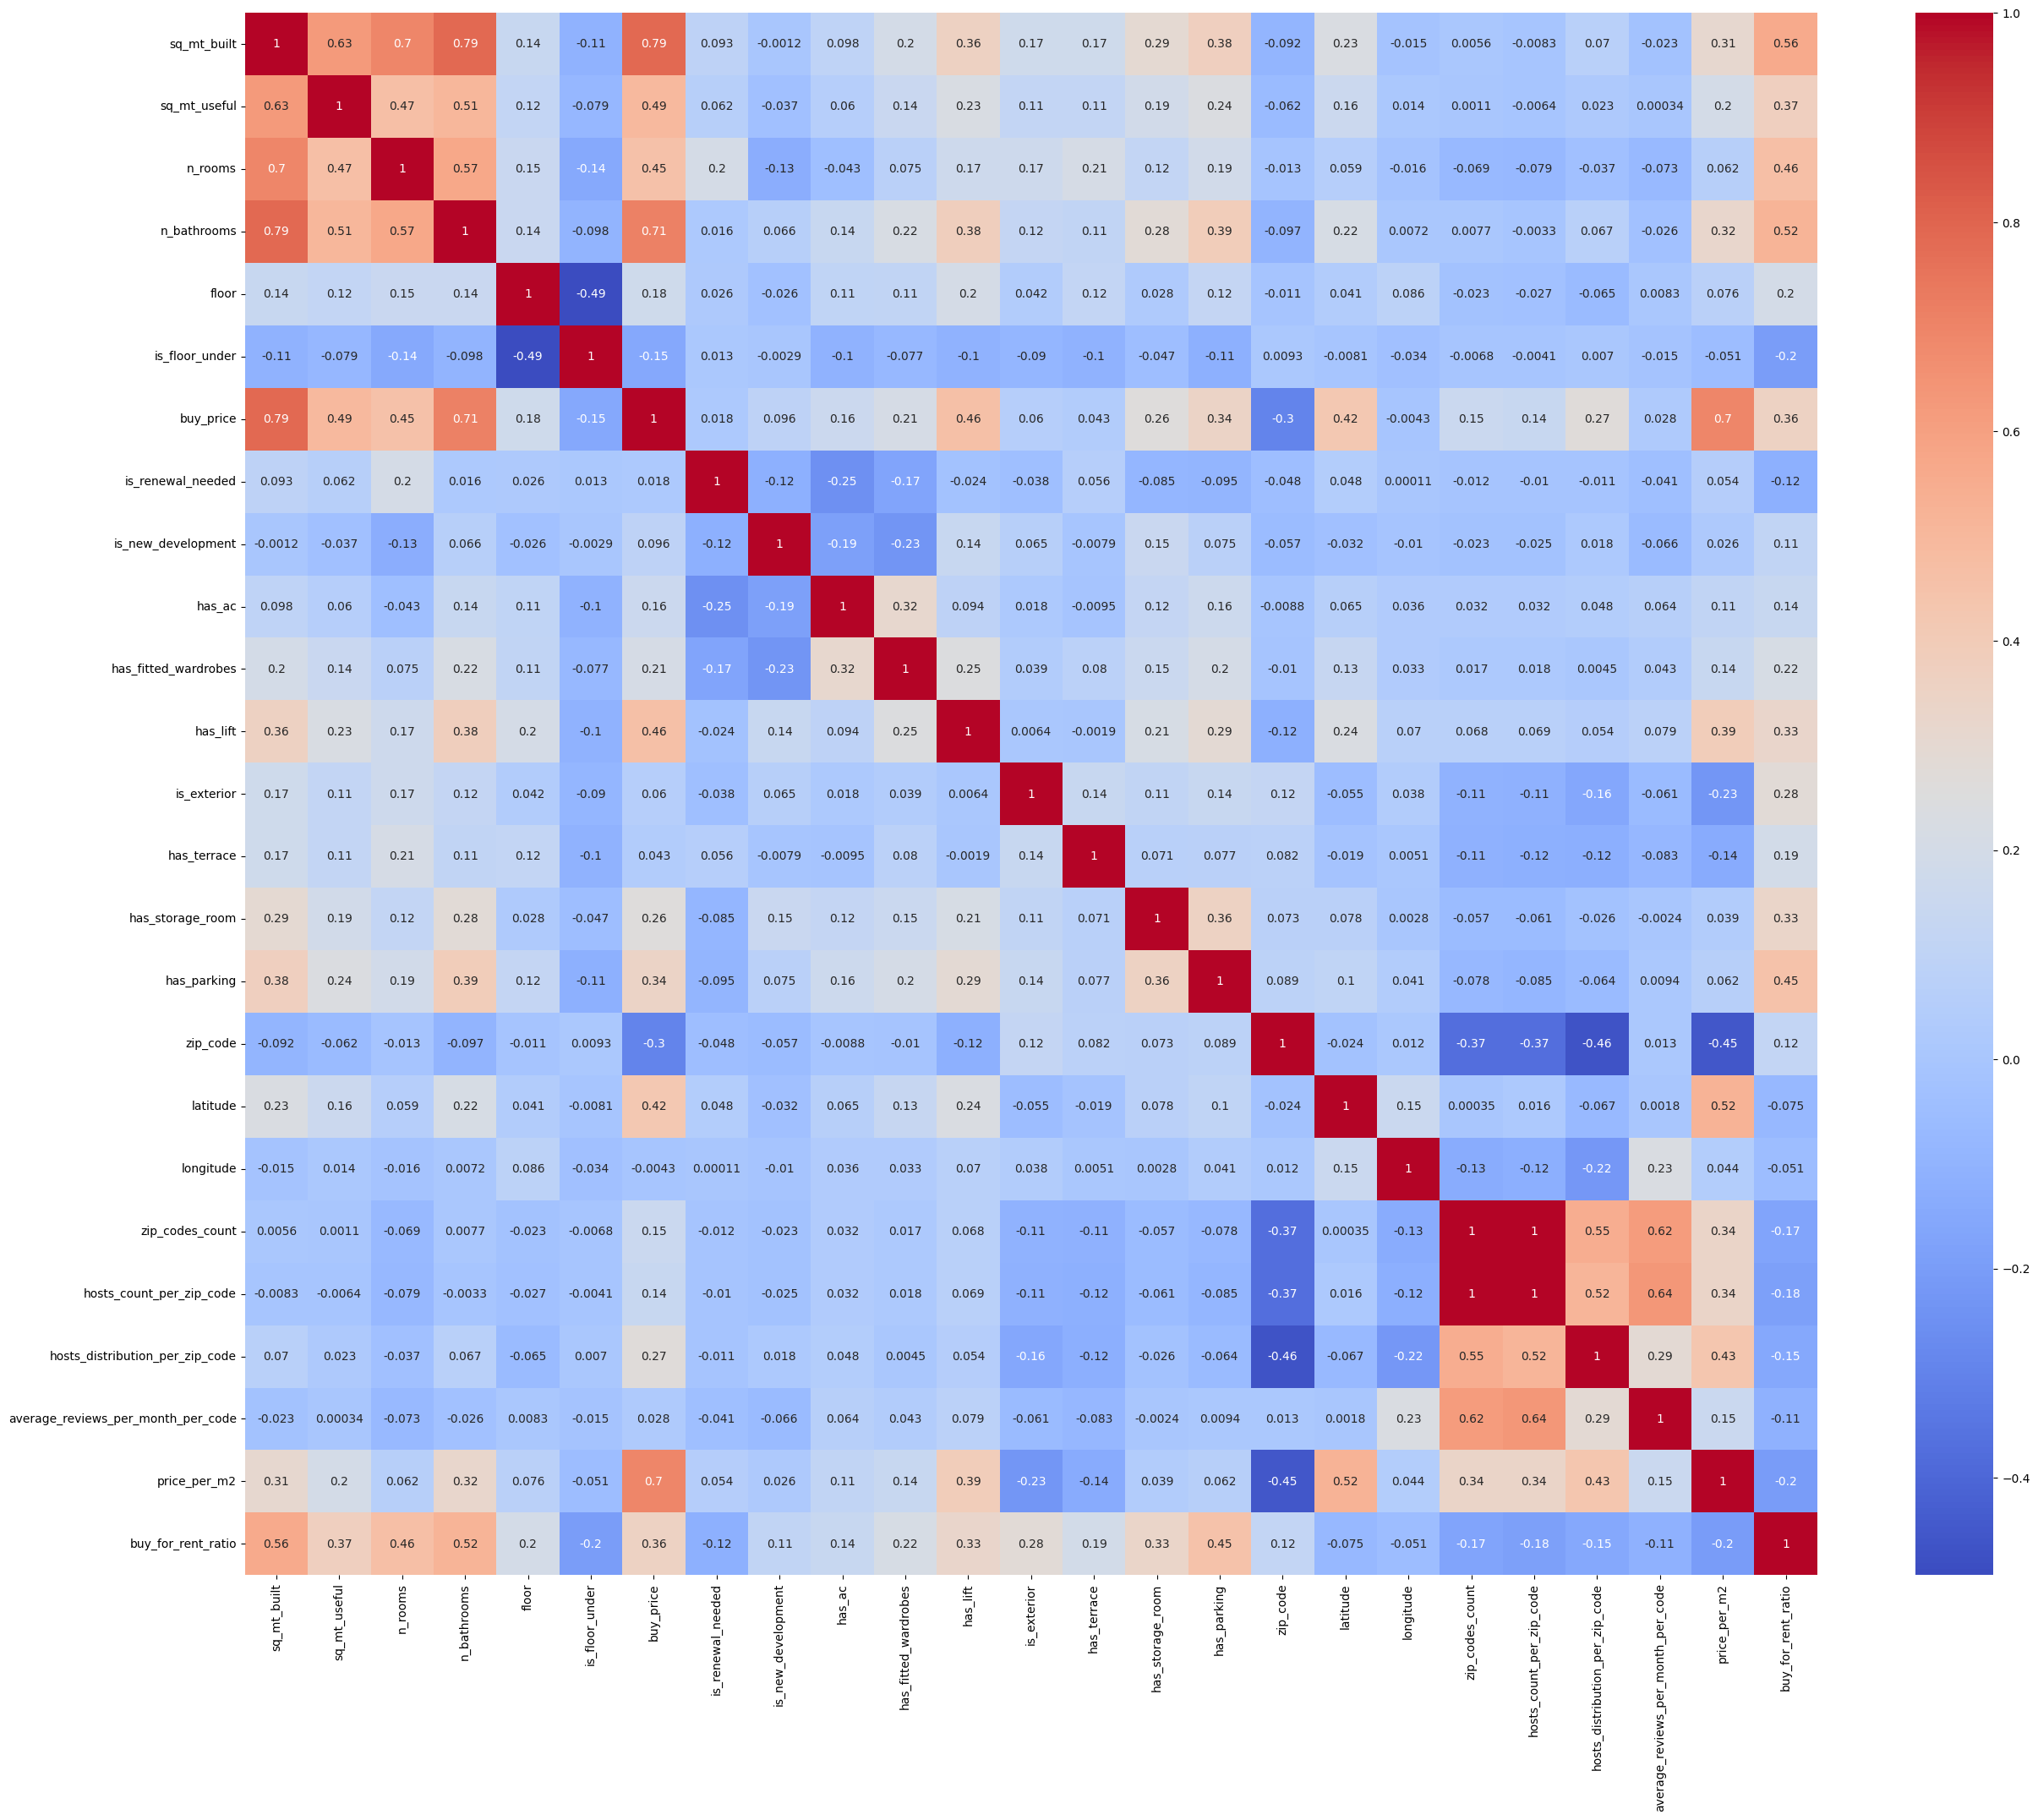

In [77]:
corr_m = prev_df.corr()
plt.figure(figsize=(30, 24))
sns.heatmap(corr_m, annot=True, cmap='coolwarm')

In [78]:
corr_m_bp = prev_df.corr()['buy_price'].sort_values(ascending=False)
corr_m_bp

buy_price                             1.000000
sq_mt_built                           0.787568
n_bathrooms                           0.708707
price_per_m2                          0.695857
sq_mt_useful                          0.493094
has_lift                              0.460857
n_rooms                               0.453064
latitude                              0.417419
buy_for_rent_ratio                    0.358460
has_parking                           0.343892
hosts_distribution_per_zip_code       0.269591
has_storage_room                      0.260814
has_fitted_wardrobes                  0.209220
floor                                 0.177487
has_ac                                0.158938
zip_codes_count                       0.148689
hosts_count_per_zip_code              0.137143
is_new_development                    0.095719
is_exterior                           0.059550
has_terrace                           0.043421
average_reviews_per_month_per_code    0.028381
is_renewal_ne

In [79]:
prev_df.drop('hosts_count_per_zip_code', axis=1, inplace=True)

In [80]:
prev_df.to_csv('datasets/analyzed_data/clean_after_null.csv')
prev_df.drop('buy_price', axis=1, inplace=True)

<h3>Estudio de valores atípicos (outliers)</h3>

Primero se va a realizar un estudio de la normalidad del dataset, posteriormente se hará un análisis de los valores normalizados para poder observar con más facilidad los outliers.

In [81]:
def plot_dist(df: pd.DataFrame) -> None:

    col = df.columns
    row_number = (len(col) // 3) + (1 if len(col) % 3 != 0 else 0)
    col_number = 3

    # Subplots
    fig, axes = plt.subplots(row_number, 3, figsize=(15, 5*row_number))
    # fig.subplots_adjust(hspace=0.5)

    # Iter through cols
    for i, columna in enumerate(col):
        fila = i // col_number
        columna_subplot = i % col_number

        if row_number > 1:
            ax = axes[fila, columna_subplot]
        else:
            ax = axes[columna_subplot]

        # Histogram
        sns.histplot(data=df, x=columna, kde=True, ax=ax)
        ax.set_xlabel('value')
        ax.set_ylabel('frec')
        ax.set_title(f'{columna}')

    plt.show()

In [82]:
# Categorical to one-hot encoding
# prev_df = pd.get_dummies(prev_df, columns=['zip_code'], dtype=np.uint8)
prev_df.drop(['zip_code', 'latitude', 'longitude'], axis=1, inplace=True)

In [83]:
# Se analizan las variables no binarias
bin = []
not_bin = []

for c in prev_df.columns.to_list():
    if set(prev_df[c].unique()) == {0, 1}:
        bin.append(c)
    elif c!='latitude' and c!='longitude' and c!='zip_code' and c!='price_per_m2' and c!='zip_codes_count': # we're not analyzing location, it's implicit into some variables, but we're using it later
        not_bin.append(c)

print(not_bin)

['sq_mt_built', 'sq_mt_useful', 'n_rooms', 'n_bathrooms', 'floor', 'hosts_distribution_per_zip_code', 'average_reviews_per_month_per_code', 'buy_for_rent_ratio']


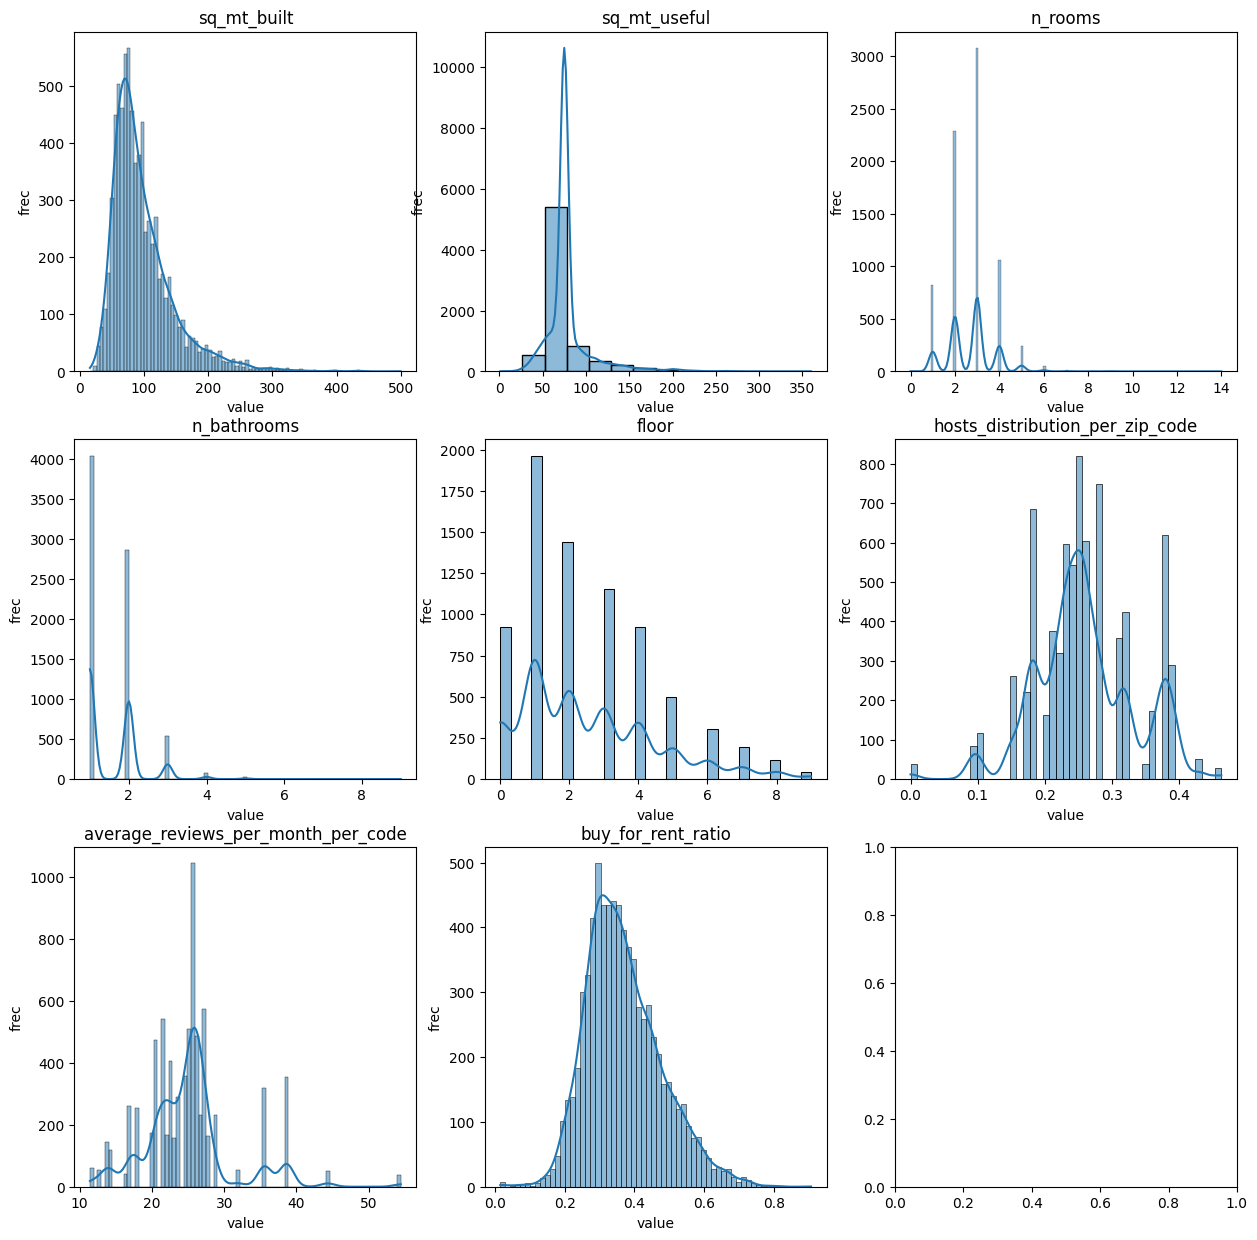

In [84]:
plot_dist(prev_df[not_bin])

In [85]:
# First analysis
columns = prev_df[not_bin].columns.to_list()
for c in columns[1:]:
    print(c)
    print(set(prev_df[c].unique()))

sq_mt_useful
{1.0, 2.0, 12.0, 13.0, 19.0, 20.0, 21.0, 22.0, 23.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 1

Shapiro antes de box-cox

In [86]:
shapiro_test = {}
for i, col in enumerate(prev_df[not_bin].columns):
    shapiro_test[prev_df[not_bin].columns[i]] = shapiro(prev_df[not_bin][prev_df[not_bin].columns[i]])
shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
shapiro_test

/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
 

,Test Statistic,p-value
sq_mt_built,0.850140,0.000000e+00
sq_mt_useful,0.658834,0.000000e+00
n_rooms,0.881926,0.000000e+00
n_bathrooms,0.725327,0.000000e+00
floor,0.909948,0.000000e+00
hosts_distribution_per_zip_code,0.970835,1.369724e-36
average_reviews_per_month_per_code,0.898754,0.000000e+00
buy_for_rent_ratio,0.975191,2.879825e-34


In [87]:
# Creamos nuevo dataframe para la transformación box-cox
prev_df_boxcox = prev_df.copy()
prev_df_boxcox[not_bin] = prev_df_boxcox[not_bin] + 1
boxcox = PowerTransformer(method='box-cox')
prev_df_boxcox[not_bin] = boxcox.fit_transform(prev_df_boxcox[not_bin])


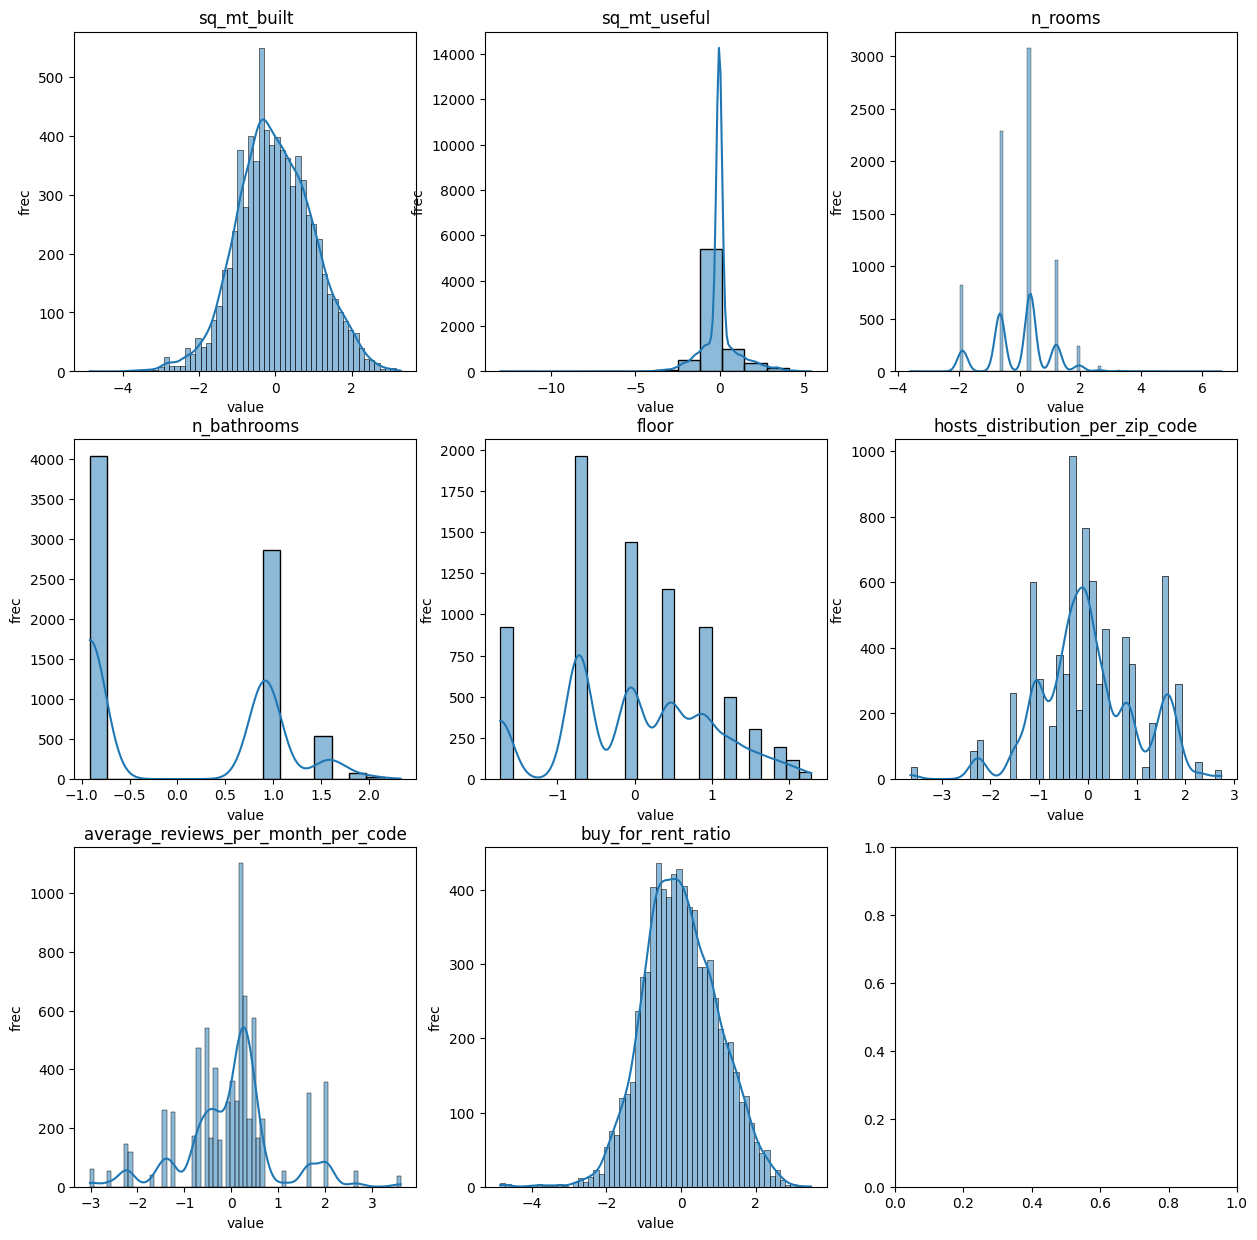

In [88]:
plot_dist(prev_df_boxcox[not_bin])

In [89]:
shapiro_test = {}
for i, col in enumerate(prev_df_boxcox[not_bin].columns):
    shapiro_test[prev_df_boxcox[not_bin].columns[i]] = shapiro(prev_df_boxcox[not_bin][prev_df_boxcox[not_bin].columns[i]])
shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
shapiro_test

/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/lgfresh/Desktop/prac2/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
 

,Test Statistic,p-value
sq_mt_built,0.997767,4.361937e-09
sq_mt_useful,0.783560,0.000000e+00
n_rooms,0.902998,0.000000e+00
n_bathrooms,0.715638,0.000000e+00
floor,0.948434,1.401298e-45
hosts_distribution_per_zip_code,0.970963,1.588867e-36
average_reviews_per_month_per_code,0.939428,0.000000e+00
buy_for_rent_ratio,0.994196,5.631184e-17


Análisis de outliers tras normalización box-cox

Text(0.5, 1.0, "outliers' box-plot")

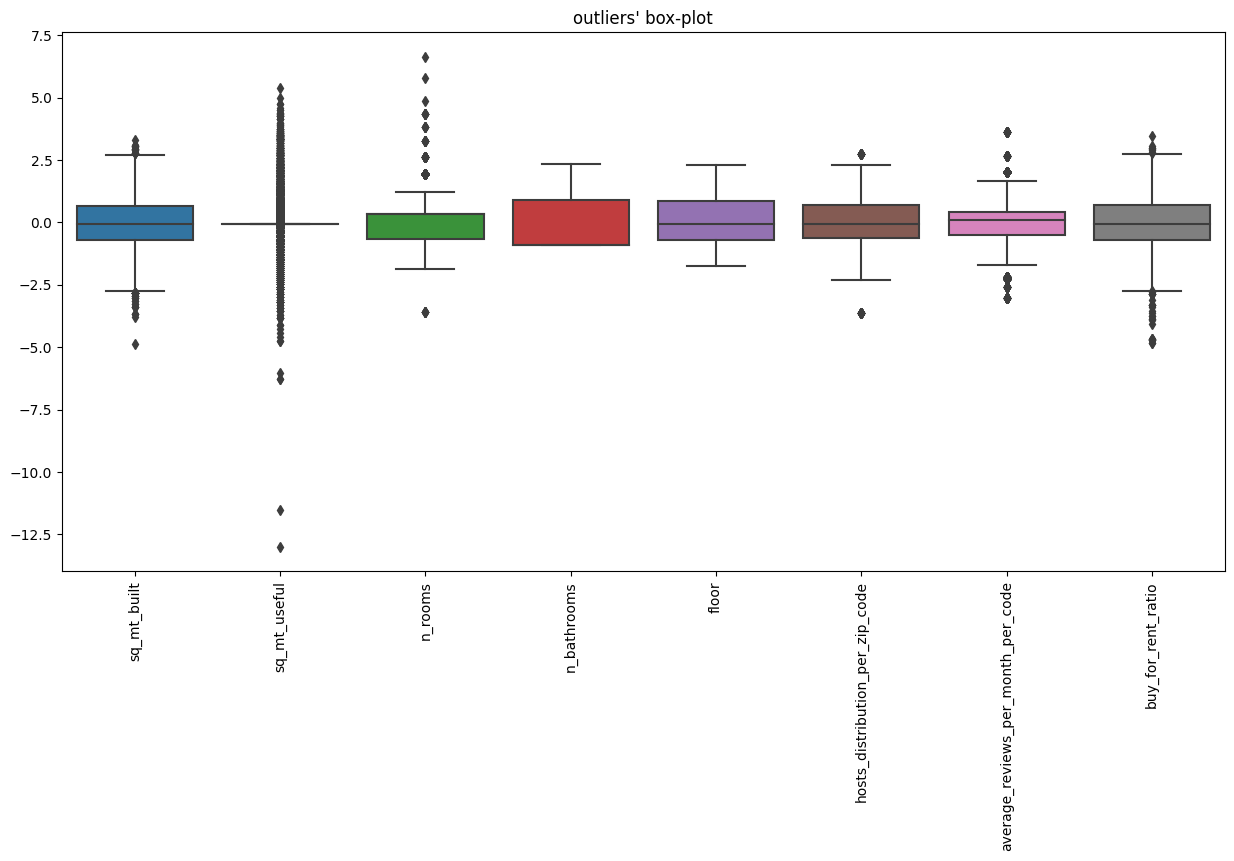

In [90]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=prev_df_boxcox[not_bin])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title("outliers' box-plot")

In [91]:
for c in prev_df_boxcox[not_bin].columns.to_list():
    iqr = np.percentile(prev_df_boxcox[c],75) - np.percentile(prev_df_boxcox[c],25)
    upper= np.percentile(prev_df_boxcox[c],75) + 1.5*iqr
    down = np.percentile(prev_df_boxcox[c],25) - 1.5*iqr
    prev_df_boxcox[c] = np.where(prev_df_boxcox[c] > upper, upper, prev_df_boxcox[c])
    prev_df_boxcox[c] = np.where(prev_df_boxcox[c] < down, down, prev_df_boxcox[c])

Text(0.5, 1.0, "outliers' box-plot")

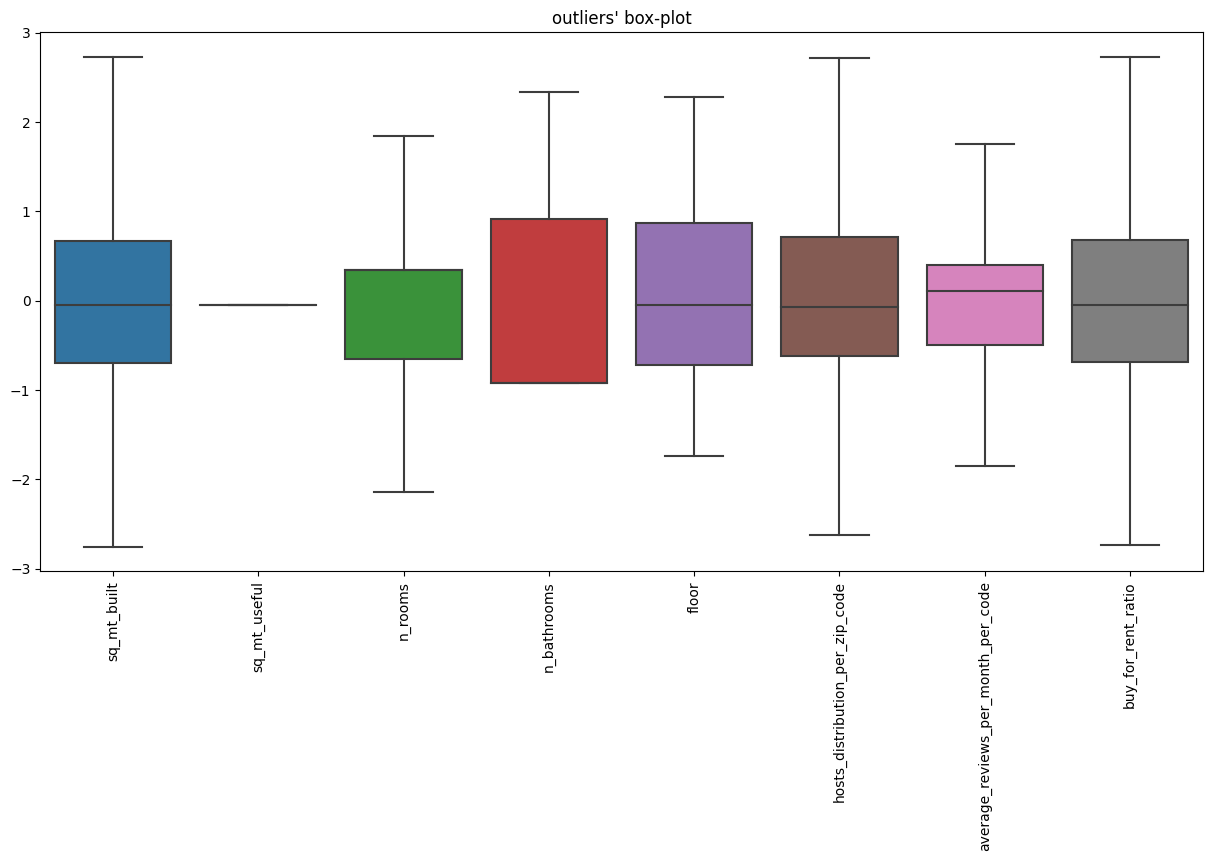

In [92]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=prev_df_boxcox[not_bin])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title("outliers' box-plot")

Análisis de outliers sin normalización box-cox

Text(0.5, 1.0, "outliers' box-plot")

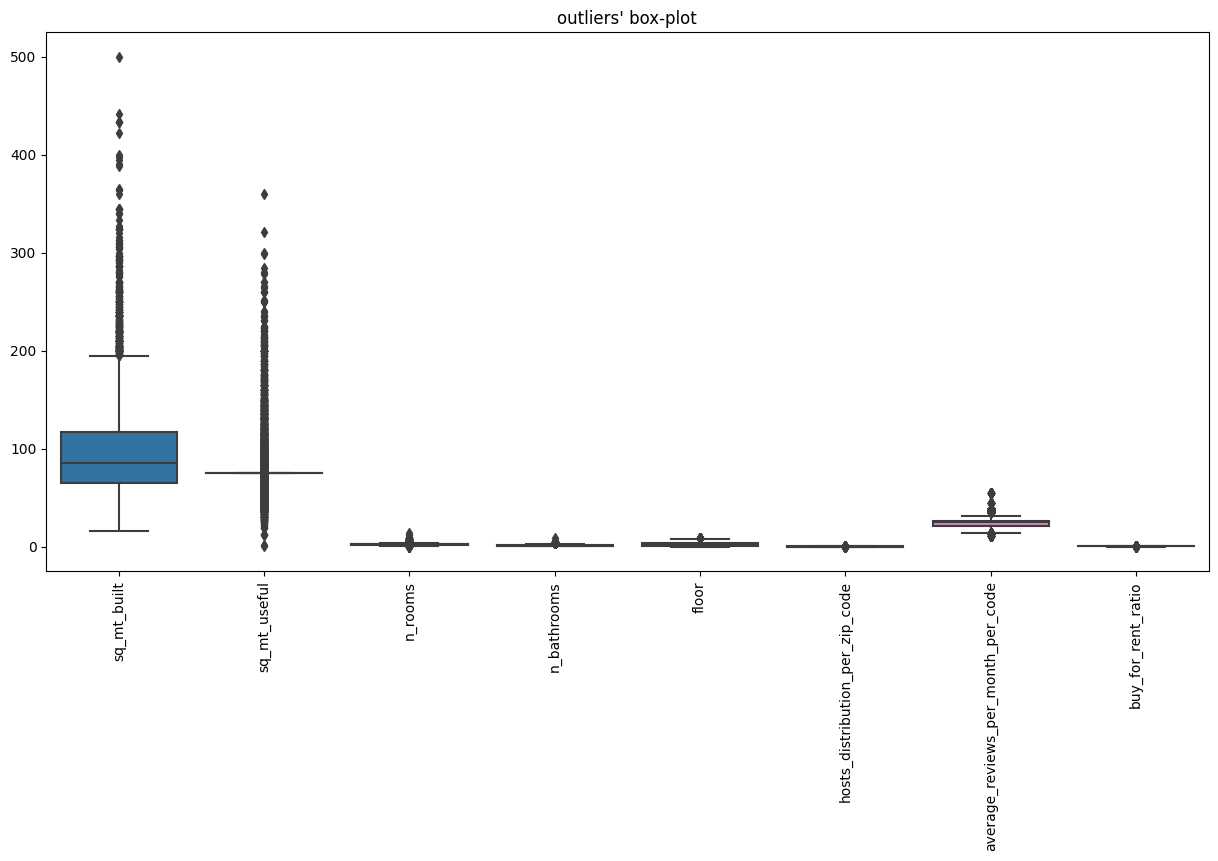

In [93]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=prev_df[not_bin])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title("outliers' box-plot")

In [94]:
for c in prev_df[not_bin].columns.to_list():
    iqr = np.percentile(prev_df[c],75) - np.percentile(prev_df[c],25)
    upper= np.percentile(prev_df[c],75) + 1.5*iqr
    down = np.percentile(prev_df[c],25) - 1.5*iqr
    prev_df[c] = np.where(prev_df[c] > upper, upper, prev_df[c])
    prev_df[c] = np.where(prev_df[c] < down, down, prev_df[c])

Text(0.5, 1.0, "outliers' box-plot")

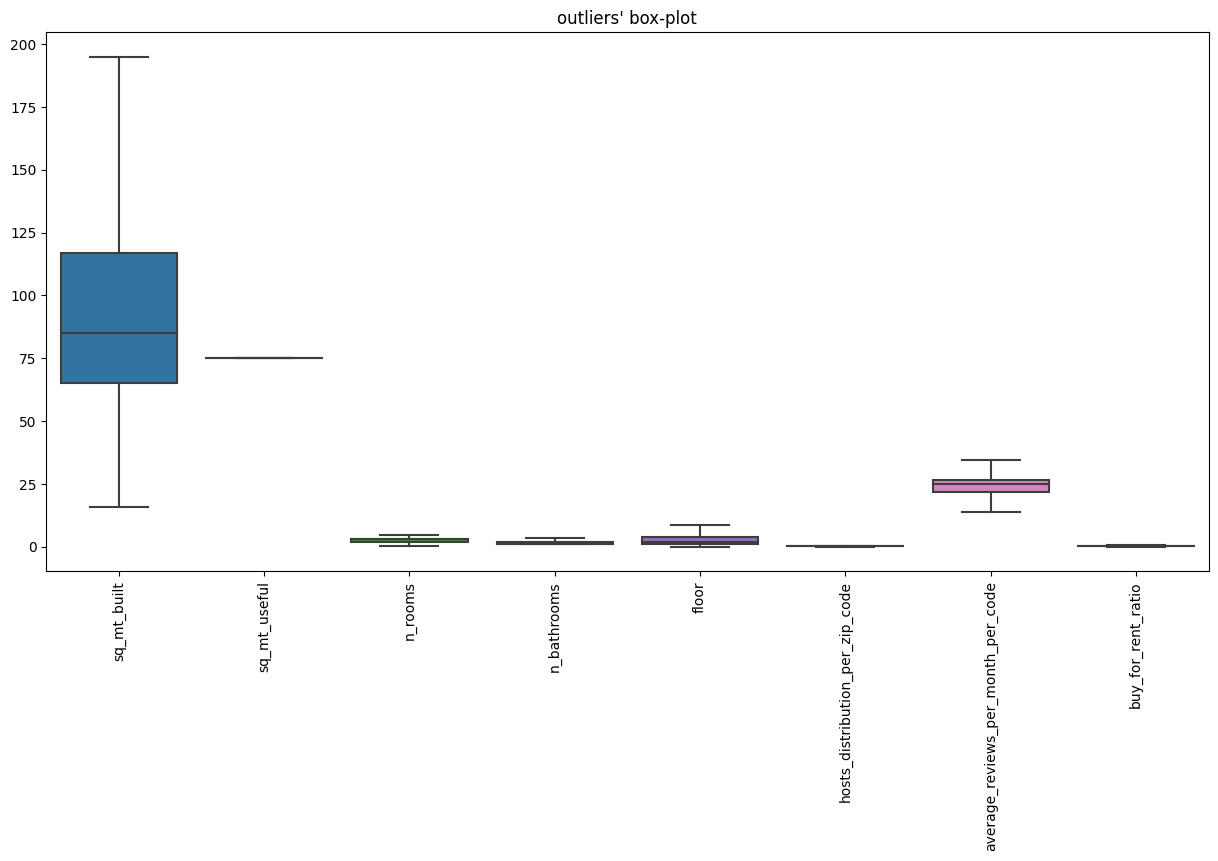

In [95]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=prev_df[not_bin])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title("outliers' box-plot")

Se guardan ambos dataset (con y sin transformación) para su posterior análisis.

In [96]:
# Guardamos datos estandarizados y no estandarizados
prev_df['buy_price'] = target
prev_df.to_csv('datasets/analyzed_data/clean_after_null_and_outliers_without_boxcox.csv')
prev_df_boxcox['buy_price'] = target
prev_df_boxcox.to_csv('datasets/analyzed_data/clean_after_null_and_outliers_with_boxcox.csv')